LSTM
==

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np
from random import shuffle

In [ ]:
filename= '../data/french_clean.txt'

In [109]:
def reverse_sequence(nouns):
    return [noun[::-1] for noun in nouns]

def pad_sequence(sequence,pad_size,pad_token):
    #returns a list with additional pad tokens to match pad_size if needed
    return sequence + [pad_token] * (pad_size - len(sequence))

def code_sequence(charseq,encodingmap,unk_token='<unk>'):
    #charseq is a sequence of chars
    return [encodingmap[char] if char in encodingmap 
            else encodingmap[unk_token] for char in charseq]

def decode_sequence(idxseq,decodingmap):
    #idxseq is a list of integers
    return [decodingmap[idx] for idx in idxseq]

In [110]:
def read_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        data = [line.strip() for line in file.readlines()]

    X, y = [], []
    for pair in data:
        noun, gender = pair.split(', ')
        reversed_noun = reverse_sequence(noun)
        X.append(reversed_noun)
        y.append(gender)
    
    return X, y

In [134]:
def vocabulary(filename, labels=False, pad_token='<pad>', unk_token='<unk>'):
    
    nouns, genders = read_data(filename)
    
    if labels:
        sym2idx = {sym: idx for idx, sym in enumerate(set(genders))}
    else:
        noun_chars = set(''.join(noun) for noun in nouns) # split the nouns into characters
        sym2idx = {sym: idx for idx, sym in enumerate(noun_chars)}
        sym2idx[pad_token] = len(sym2idx)
        sym2idx[unk_token] = len(sym2idx)

    idx2sym = {idx: sym for sym, idx in sym2idx.items()}

    return idx2sym, sym2idx

In [113]:
# Author: Benoit Crabbé (with slight modifications)
class DataGenerator:

      def __init__(self, filename, pad_token='<pad>', unk_token='<unk>'):

          self.pad_token = pad_token
          self.unk_token = unk_token

          self.input_idx2sym,self.input_sym2idx   = vocabulary(filename,False)
          self.output_idx2sym,self.output_sym2idx = vocabulary(filename,True)

          nouns, genders = read_data(filename)
          self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(nouns, genders, test_size=0.2)

      def generate_batches(self,batch_size,validation=False):

          if validation:
              X = self.X_test
              y = self.y_test
          else:
              X = self.X_train
              y = self.y_train

          assert(len(X) == len(y))

          N     = len(X)
          idxes = list(range(N))

          # Data ordering
          shuffle(idxes)
          idxes.sort(key=lambda idx: len(X[idx]))

          # batch generation
          bstart = 0
          while bstart < N:
              bend        = min(bstart+batch_size,N)
              batch_idxes = idxes[bstart:bend]
              batch_len   = max(len(X[idx]) for idx in batch_idxes)
              Xpad        = [pad_sequence(X[idx],batch_len,self.pad_token)  for idx in batch_idxes]
              seqX        = [code_sequence(x,self.input_sym2idx,self.unk_token) for x in Xpad]
              seqY        = [self.output_sym2idx[y[idx]] for idx in batch_idxes]

              assert(len(seqX) == len(seqY))
              yield (seqX,seqY)
              bstart += batch_size

Model
==

Train the model by feeding it words in reverse order (since we want to start from the end of the word) and the corresponding genders. The model will learn to predict the gender based on the characters seen so far.

Takes preprocessed words as input:
- tokenized into characters 
- each character mapped to a unique integer id (same with each gender)
- sequences should be padded so they all have the same length

In [153]:
class GenderLSTM(nn.Module):
    def __init__(self, datagenerator, embedding_dim, hidden_dim, device='cpu'):
        super(GenderLSTM, self).__init__()
        invocab_size   = len(datagenerator.input_idx2sym)
        outvocab_size  = len(datagenerator.output_idx2sym)
        self.embedding = nn.Embedding(invocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, outvocab_size)

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        _, (hidden, _) = self.lstm(embeds)
        out = self.fc(hidden.squeeze(0))
        return out  # shape: (batch_size, num_classes) 

    def train_model(self, datagenerator, n_epochs, batch_size, learning_rate=0.001, device='cpu'):
        device = torch.device(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        self.avg_train_accuracies = []
        self.avg_valid_accuracies = []
        self.avg_valid_losses = []
        
        for epoch in range(n_epochs):
            print(f'Epoch: {epoch}')
            batch_train_losses = []
            batch_train_accuracies = []
            batch_dev_losses = []
            batch_dev_accuracies = []
            
            self.train()
            for inputs, labels in datagenerator.generate_batches(batch_size):
                X = torch.LongTensor(inputs).to(device)
                Y = torch.LongTensor(labels).to(device) # shape: (batch_size)

                optimizer.zero_grad()
                Y_pred = self.forward(X)    # shape: (batch_size, num_classes)
                loss = criterion(Y_pred, Y)
                loss.backward()
                optimizer.step()
                batch_train_losses.append(loss.item())

                # accuracy computation
                pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
                mask = (Y != pad_idx)   # padding tokens should be ignored when calculating accuracy
                Yargmax = torch.argmax(Y_pred,dim=1)
                correct = torch.sum((Yargmax == Y) * mask)
                total = torch.sum(mask)
                train_acc = float(correct)/float(total)
                batch_train_accuracies.append(train_acc)

            self.eval()
            for val_inputs, val_labels in datagenerator.generate_batches(batch_size, validation=True):
                with torch.no_grad():
                    X_val = torch.LongTensor(val_inputs).to(device)
                    Y_val = torch.LongTensor(val_labels).to(device)

                    Y_val_pred = self.forward(X_val)
                    loss = criterion(Y_val_pred, Y_val)
                    batch_dev_losses.append(loss.item())

                    # accuracy computation
                    mask = (Y_val != pad_idx)
                    Yargmax = torch.argmax(Y_val_pred,dim=1)
                    correct = torch.sum((Yargmax == Y_val) * mask)
                    total = torch.sum(mask)
                    dev_acc = float(correct)/float(total)
                    batch_dev_accuracies.append(dev_acc)

            # store & report metrics at the end of each epoch
            avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
            avg_train_acc = sum(batch_train_accuracies) / len(batch_train_accuracies)
            avg_dev_loss = sum(batch_dev_losses) / len(batch_dev_losses)
            avg_dev_acc = sum(batch_dev_accuracies) / len(batch_dev_accuracies)

            self.avg_train_accuracies.append(avg_train_acc)
            self.avg_valid_accuracies.append(avg_dev_acc)
            self.avg_valid_losses.append(avg_dev_loss)

            print(f'Train Loss: {avg_train_loss * 100:.2f}%')
            print(f'Train Accuracy: {avg_train_acc * 100:.2f}%')        
            print(f'Valid Loss: {avg_dev_loss * 100:.2f}%')
            print(f'Valid Accuracy: {avg_dev_acc * 100:.2f}%')
            print('-' * 100)



In [154]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 64
hidden_dim = 128
n_epochs = 10
batch_size = 32

data_generator = DataGenerator(filename)
model = GenderLSTM(data_generator, embedding_dim, hidden_dim, device=DEVICE)
model.train_model(data_generator,n_epochs,batch_size,device=DEVICE)

Epoch: 0
Train Loss: 39.21%
Train Accuracy: 82.04%
Valid Loss: 48.63%
Valid Accuracy: 80.55%
----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 37.84%
Train Accuracy: 82.78%
Valid Loss: 48.08%
Valid Accuracy: 80.97%
----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 37.02%
Train Accuracy: 83.21%
Valid Loss: 48.19%
Valid Accuracy: 81.07%
----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 36.43%
Train Accuracy: 83.50%
Valid Loss: 48.23%
Valid Accuracy: 80.85%
----------------------------------------------------------------------------------------------------
Epoch: 4
Train Loss: 36.08%
Train Accuracy: 83.67%
Valid Loss: 48.86%
Valid Accuracy: 81.01%
----------------------------------------------------------------------------------------------------
Epoch: 5
Train Loss: 35.61%
Tr

In [156]:
import matplotlib.pyplot as plt

def plot(train_acc, valid_acc, valid_losses):

    x_axis = range(1, len(valid_losses) + 1)

    plt.plot(x_axis ,train_acc, marker='o', label='Training Accuracies')
    plt.plot(x_axis, valid_acc, marker='o', label='Validation Accuracies')
    plt.plot(x_axis, valid_losses, marker='o', label='Loss')

    plt.title('Loss & Accuracy Evolution Over Epochs')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

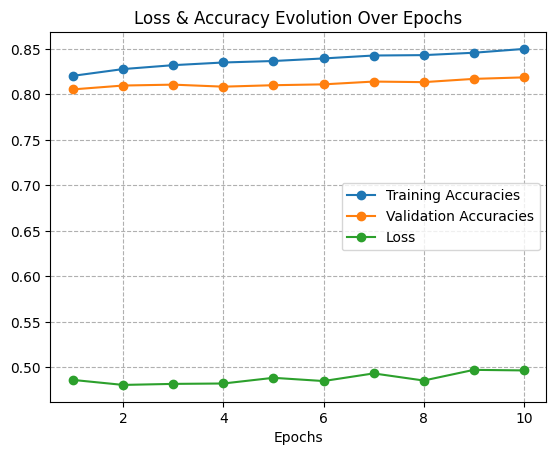

In [157]:
plot(model.avg_train_accuracies, model.avg_valid_accuracies, model.avg_valid_losses)

In [162]:
%%capture
%pip install GPUtil

In [161]:
import GPUtil

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

if not gpus:
    print("No GPU available.")
else:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i + 1}: {gpu.name}")

No GPU available.
